In [72]:
import pandas as pd
import numpy as np

In [73]:
df = pd.read_csv("Terry_Stops_20250719.csv")
df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,46 - 55,-1,2.020000e+13,481899,Field Contact,NaN,8544,1993,Female,Hispanic,...,47:00.0,-,-,-,NORTH PCT 2ND WATCH - B/N RELIEF,N,N,West,Q,Q2
1,18 - 25,-1,2.020000e+13,445585,Offense Report,NaN,8588,1986,Female,White,...,43:00.0,"OBS WEAPN-IP/JO-GUN,DEADLY WPN (NO THRT/ASLT/D...","WEAPON, PERSON WITH - GUN",911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,J,J1
2,26 - 35,-1,2.020000e+13,234548,Offense Report,NaN,4852,1953,Male,Asian,...,36:00.0,DISTURBANCE,THEFT - SHOPLIFT,911,NORTH PCT 2ND W - LINCOLN - PLATOON 1,N,N,North,L,L3
3,36 - 45,49326761681,2.020000e+13,49327076666,Field Contact,Knife/Cutting/Stabbing Instrument,7766,1984,Male,White,...,25:58.0,OBS - DOWN - CHECK FOR PERSON DOWN,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,WEST PCT 1ST W - QUEEN (DAVID) - PLATOON 1,N,Y,West,K,K3
4,Jan-17,48319519002,2.020000e+13,48319446887,Field Contact,-,8765,1992,Male,Two or More Races,...,53:15.0,MVC - HIT AND RUN,TRAFFIC - MV COLLISION INVESTIGATION,911,SOUTH PCT 3RD W - ROBERT (OCEAN) - PLATOON 1,N,N,South,R,R2


In [124]:
df.columns

Index(['Subject Age Group', 'Subject ID', 'GO / SC Num', 'Terry Stop ID',
       'Stop Resolution', 'Officer ID', 'Officer YOB', 'Officer Gender',
       'Officer Race', 'Subject Perceived Race', 'Subject Perceived Gender',
       'Reported Date', 'Reported Time', 'Initial Call Type',
       'Final Call Type', 'Call Type', 'Officer Squad', 'Arrest Flag',
       'Frisk Flag', 'Precinct', 'Sector', 'Beat', 'Weapon Type Missing',
       'Subject Identified'],
      dtype='object')

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64186 entries, 0 to 64185
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Subject Age Group         64186 non-null  object 
 1   Subject ID                64186 non-null  int64  
 2   GO / SC Num               64186 non-null  float64
 3   Terry Stop ID             64186 non-null  int64  
 4   Stop Resolution           64186 non-null  object 
 5   Weapon Type               31621 non-null  object 
 6   Officer ID                64186 non-null  object 
 7   Officer YOB               64186 non-null  int64  
 8   Officer Gender            64186 non-null  object 
 9   Officer Race              64186 non-null  object 
 10  Subject Perceived Race    64186 non-null  object 
 11  Subject Perceived Gender  64186 non-null  object 
 12  Reported Date             64186 non-null  object 
 13  Reported Time             64186 non-null  object 
 14  Initia

In [75]:
df.isnull().sum()

Subject Age Group               0
Subject ID                      0
GO / SC Num                     0
Terry Stop ID                   0
Stop Resolution                 0
Weapon Type                 32565
Officer ID                      0
Officer YOB                     0
Officer Gender                  0
Officer Race                    0
Subject Perceived Race          0
Subject Perceived Gender        0
Reported Date                   0
Reported Time                   0
Initial Call Type               0
Final Call Type                 0
Call Type                       0
Officer Squad                 563
Arrest Flag                     0
Frisk Flag                      0
Precinct                        0
Sector                          0
Beat                            0
dtype: int64

- Weapon Type is missing a lot of values and might be relevant to model-building.
- Check its importance before building a model and assess whether imputation or dropping it completely is the right move

In [76]:
missing_percent = df['Weapon Type'].isnull().mean() * 100
print(f"Missing: {missing_percent:.2f}%")


Missing: 50.74%


In [77]:
df['Weapon Type Missing'] = df['Weapon Type'].isnull().astype(int)
df

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Weapon Type Missing
0,46 - 55,-1,2.020000e+13,481899,Field Contact,NaN,8544,1993,Female,Hispanic,...,-,-,-,NORTH PCT 2ND WATCH - B/N RELIEF,N,N,West,Q,Q2,1
1,18 - 25,-1,2.020000e+13,445585,Offense Report,NaN,8588,1986,Female,White,...,"OBS WEAPN-IP/JO-GUN,DEADLY WPN (NO THRT/ASLT/D...","WEAPON, PERSON WITH - GUN",911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,J,J1,1
2,26 - 35,-1,2.020000e+13,234548,Offense Report,NaN,4852,1953,Male,Asian,...,DISTURBANCE,THEFT - SHOPLIFT,911,NORTH PCT 2ND W - LINCOLN - PLATOON 1,N,N,North,L,L3,1
3,36 - 45,49326761681,2.020000e+13,49327076666,Field Contact,Knife/Cutting/Stabbing Instrument,7766,1984,Male,White,...,OBS - DOWN - CHECK FOR PERSON DOWN,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,WEST PCT 1ST W - QUEEN (DAVID) - PLATOON 1,N,Y,West,K,K3,0
4,Jan-17,48319519002,2.020000e+13,48319446887,Field Contact,-,8765,1992,Male,Two or More Races,...,MVC - HIT AND RUN,TRAFFIC - MV COLLISION INVESTIGATION,911,SOUTH PCT 3RD W - ROBERT (OCEAN) - PLATOON 1,N,N,South,R,R2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64181,26 - 35,7738643372,2.020000e+13,19551625274,Field Contact,-,8486,1992,Male,Asian,...,ASLT - DV,DV - DOMESTIC VIOL/ASLT (ARREST MANDATORY),"TELEPHONE OTHER, NOT 911",SOUTHWEST PCT 2ND W - FRANK - PLATOON 2,N,N,Southwest,F,F1,0
64182,26 - 35,-1,2.020000e+13,199148,Arrest,NaN,8337,1984,Male,Two or More Races,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,WARRANT SERVICES - MISDEMEANOR,ONVIEW,NORTH PCT 1ST W - BOY (JOHN) - PLATOON 1,N,Y,North,B,B2,1
64183,26 - 35,-1,2.020000e+13,343990,Arrest,NaN,8518,1987,Male,Asian,...,OBS - DOWN - CHECK FOR PERSON DOWN,SUSPICIOUS CIRCUM. - SUSPICIOUS VEHICLE,911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,L,L2,1
64184,36 - 45,13852686838,2.020000e+13,57880886680,Field Contact,-,8769,1995,Male,Declined to Answer,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,EAST PCT 3RD W - EDWARD (CHARLIE) - PLATOON 1,N,N,East,E,E2,0


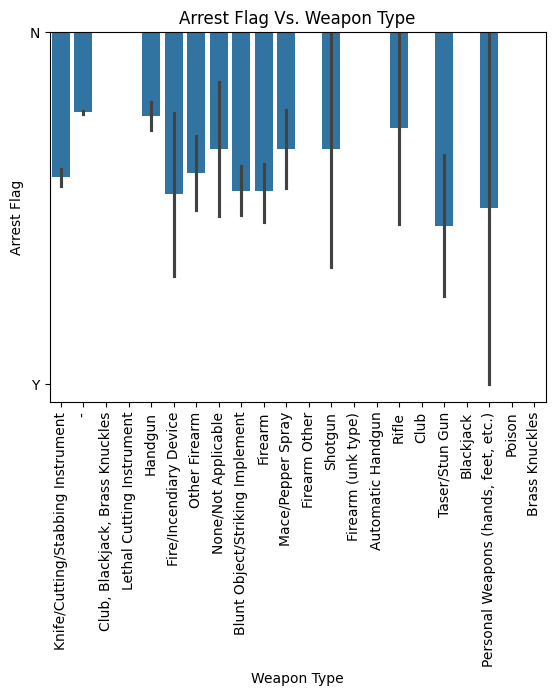

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='Weapon Type', y='Arrest Flag', data=df)
plt.title("Arrest Flag Vs. Weapon Type")
plt.xticks(rotation=90)
plt.show()


In [79]:
#Scoring Using Missingness Indicator (1 = missing, 0 = weapon type present)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

model_missing_only = RandomForestClassifier(random_state=42)
score_missing_only = cross_val_score(
    model_missing_only,
    df[['Weapon Type Missing']],
    df['Arrest Flag'],
    cv=5
).mean()

print(f"Score using only missingness indicator: {score_missing_only:.4f}")


Score using only missingness indicator: 0.8874


In [80]:
# Scoring using actual Weapon Type values 
df_notnull = df.dropna(subset=['Weapon Type'])

# One-hot encode Weapon Type
X_weapon_encoded = pd.get_dummies(df_notnull[['Weapon Type']], drop_first=True)
y_notnull = df_notnull['Arrest Flag']

model_encoded = RandomForestClassifier(random_state=42)
score_encoded = cross_val_score(
    model_encoded,
    X_weapon_encoded,
    y_notnull,
    cv=5
).mean()

print(f"Score using actual Weapon Type values (non-missing): {score_encoded:.4f}")


Score using actual Weapon Type values (non-missing): 0.7712


In [81]:
# Scoring after imputing and encoding Weapon Type
df['Weapon_Type_filled'] = df['Weapon Type'].fillna('Unknown')
X_full_encoded = pd.get_dummies(df[['Weapon_Type_filled']], drop_first=True)

model_imputed = RandomForestClassifier(random_state=42)
score_imputed = cross_val_score(
    model_imputed,
    X_full_encoded,
    df['Arrest Flag'],
    cv=5
).mean()

print(f"Score after imputing and encoding Weapon Type: {score_imputed:.4f}")


Score after imputing and encoding Weapon Type: 0.8870


### Model Comparison Results
| Model Version                                  | CV Score   | Interpretation                                                            |
| ---------------------------------------------- | ---------- | ------------------------------------------------------------------------- |
|  **Missingness indicator only**               | **0.8874** | Highest score — strong signal just from whether the value is missing.     |
|  **Actual Weapon Type values** (no missing) | 0.7712     | Much lower — actual values are *less predictive* than missingness itself. |
|  **Imputed + Encoded Weapon Type**            | 0.8870     | Almost same as missingness only — imputation doesn't add useful signal.   |  

- Missingness > Actual Data:

    - The fact that Weapon Type is missing tells the model more about arrest likelihood than the actual weapon type does.

    - Possibly: unreported weapon types are correlated with non-arrests.

- Imputing Doesn’t Improve the Model

- Best Option for Modeling:

    - Keep the missingness indicator as a feature "Weapon_Type_missing" and drop the "Weapon Type" column


In [82]:
df

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Weapon Type Missing,Weapon_Type_filled
0,46 - 55,-1,2.020000e+13,481899,Field Contact,NaN,8544,1993,Female,Hispanic,...,-,-,NORTH PCT 2ND WATCH - B/N RELIEF,N,N,West,Q,Q2,1,Unknown
1,18 - 25,-1,2.020000e+13,445585,Offense Report,NaN,8588,1986,Female,White,...,"WEAPON, PERSON WITH - GUN",911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,J,J1,1,Unknown
2,26 - 35,-1,2.020000e+13,234548,Offense Report,NaN,4852,1953,Male,Asian,...,THEFT - SHOPLIFT,911,NORTH PCT 2ND W - LINCOLN - PLATOON 1,N,N,North,L,L3,1,Unknown
3,36 - 45,49326761681,2.020000e+13,49327076666,Field Contact,Knife/Cutting/Stabbing Instrument,7766,1984,Male,White,...,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,WEST PCT 1ST W - QUEEN (DAVID) - PLATOON 1,N,Y,West,K,K3,0,Knife/Cutting/Stabbing Instrument
4,Jan-17,48319519002,2.020000e+13,48319446887,Field Contact,-,8765,1992,Male,Two or More Races,...,TRAFFIC - MV COLLISION INVESTIGATION,911,SOUTH PCT 3RD W - ROBERT (OCEAN) - PLATOON 1,N,N,South,R,R2,0,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64181,26 - 35,7738643372,2.020000e+13,19551625274,Field Contact,-,8486,1992,Male,Asian,...,DV - DOMESTIC VIOL/ASLT (ARREST MANDATORY),"TELEPHONE OTHER, NOT 911",SOUTHWEST PCT 2ND W - FRANK - PLATOON 2,N,N,Southwest,F,F1,0,-
64182,26 - 35,-1,2.020000e+13,199148,Arrest,NaN,8337,1984,Male,Two or More Races,...,WARRANT SERVICES - MISDEMEANOR,ONVIEW,NORTH PCT 1ST W - BOY (JOHN) - PLATOON 1,N,Y,North,B,B2,1,Unknown
64183,26 - 35,-1,2.020000e+13,343990,Arrest,NaN,8518,1987,Male,Asian,...,SUSPICIOUS CIRCUM. - SUSPICIOUS VEHICLE,911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,L,L2,1,Unknown
64184,36 - 45,13852686838,2.020000e+13,57880886680,Field Contact,-,8769,1995,Male,Declined to Answer,...,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,EAST PCT 3RD W - EDWARD (CHARLIE) - PLATOON 1,N,N,East,E,E2,0,-


In [83]:
features = [..., 'Weapon Type Missing']  # include it
df.drop(columns=['Weapon Type', 'Weapon_Type_filled'], inplace=True)  #drop

In [84]:
df

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,...,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Weapon Type Missing
0,46 - 55,-1,2.020000e+13,481899,Field Contact,8544,1993,Female,Hispanic,White,...,-,-,-,NORTH PCT 2ND WATCH - B/N RELIEF,N,N,West,Q,Q2,1
1,18 - 25,-1,2.020000e+13,445585,Offense Report,8588,1986,Female,White,Black or African American,...,"OBS WEAPN-IP/JO-GUN,DEADLY WPN (NO THRT/ASLT/D...","WEAPON, PERSON WITH - GUN",911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,J,J1,1
2,26 - 35,-1,2.020000e+13,234548,Offense Report,4852,1953,Male,Asian,White,...,DISTURBANCE,THEFT - SHOPLIFT,911,NORTH PCT 2ND W - LINCOLN - PLATOON 1,N,N,North,L,L3,1
3,36 - 45,49326761681,2.020000e+13,49327076666,Field Contact,7766,1984,Male,White,Native Hawaiian or Other Pacific Islander,...,OBS - DOWN - CHECK FOR PERSON DOWN,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,WEST PCT 1ST W - QUEEN (DAVID) - PLATOON 1,N,Y,West,K,K3,0
4,Jan-17,48319519002,2.020000e+13,48319446887,Field Contact,8765,1992,Male,Two or More Races,Black or African American,...,MVC - HIT AND RUN,TRAFFIC - MV COLLISION INVESTIGATION,911,SOUTH PCT 3RD W - ROBERT (OCEAN) - PLATOON 1,N,N,South,R,R2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64181,26 - 35,7738643372,2.020000e+13,19551625274,Field Contact,8486,1992,Male,Asian,American Indian or Alaska Native,...,ASLT - DV,DV - DOMESTIC VIOL/ASLT (ARREST MANDATORY),"TELEPHONE OTHER, NOT 911",SOUTHWEST PCT 2ND W - FRANK - PLATOON 2,N,N,Southwest,F,F1,0
64182,26 - 35,-1,2.020000e+13,199148,Arrest,8337,1984,Male,Two or More Races,White,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,WARRANT SERVICES - MISDEMEANOR,ONVIEW,NORTH PCT 1ST W - BOY (JOHN) - PLATOON 1,N,Y,North,B,B2,1
64183,26 - 35,-1,2.020000e+13,343990,Arrest,8518,1987,Male,Asian,Unknown,...,OBS - DOWN - CHECK FOR PERSON DOWN,SUSPICIOUS CIRCUM. - SUSPICIOUS VEHICLE,911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,L,L2,1
64184,36 - 45,13852686838,2.020000e+13,57880886680,Field Contact,8769,1995,Male,Declined to Answer,White,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,EAST PCT 3RD W - EDWARD (CHARLIE) - PLATOON 1,N,N,East,E,E2,0


In [85]:
df.isnull().sum()

Subject Age Group             0
Subject ID                    0
GO / SC Num                   0
Terry Stop ID                 0
Stop Resolution               0
Officer ID                    0
Officer YOB                   0
Officer Gender                0
Officer Race                  0
Subject Perceived Race        0
Subject Perceived Gender      0
Reported Date                 0
Reported Time                 0
Initial Call Type             0
Final Call Type               0
Call Type                     0
Officer Squad               563
Arrest Flag                   0
Frisk Flag                    0
Precinct                      0
Sector                        0
Beat                          0
Weapon Type Missing           0
dtype: int64

In [86]:
#Officer Squad column has 563 missing values, impute using mode because its categorical
df["Officer Squad"].mode()

0    TRAINING - FIELD TRAINING SQUAD
Name: Officer Squad, dtype: object

In [87]:
impute_value = df["Officer Squad"].mode()[0]
df.fillna({"Officer Squad": impute_value}, inplace=True)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64186 entries, 0 to 64185
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Subject Age Group         64186 non-null  object 
 1   Subject ID                64186 non-null  int64  
 2   GO / SC Num               64186 non-null  float64
 3   Terry Stop ID             64186 non-null  int64  
 4   Stop Resolution           64186 non-null  object 
 5   Officer ID                64186 non-null  object 
 6   Officer YOB               64186 non-null  int64  
 7   Officer Gender            64186 non-null  object 
 8   Officer Race              64186 non-null  object 
 9   Subject Perceived Race    64186 non-null  object 
 10  Subject Perceived Gender  64186 non-null  object 
 11  Reported Date             64186 non-null  object 
 12  Reported Time             64186 non-null  object 
 13  Initial Call Type         64186 non-null  object 
 14  Final 

In [89]:
df.drop_duplicates(subset= ["Terry Stop ID"])

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,...,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Weapon Type Missing
0,46 - 55,-1,2.020000e+13,481899,Field Contact,8544,1993,Female,Hispanic,White,...,-,-,-,NORTH PCT 2ND WATCH - B/N RELIEF,N,N,West,Q,Q2,1
1,18 - 25,-1,2.020000e+13,445585,Offense Report,8588,1986,Female,White,Black or African American,...,"OBS WEAPN-IP/JO-GUN,DEADLY WPN (NO THRT/ASLT/D...","WEAPON, PERSON WITH - GUN",911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,J,J1,1
2,26 - 35,-1,2.020000e+13,234548,Offense Report,4852,1953,Male,Asian,White,...,DISTURBANCE,THEFT - SHOPLIFT,911,NORTH PCT 2ND W - LINCOLN - PLATOON 1,N,N,North,L,L3,1
3,36 - 45,49326761681,2.020000e+13,49327076666,Field Contact,7766,1984,Male,White,Native Hawaiian or Other Pacific Islander,...,OBS - DOWN - CHECK FOR PERSON DOWN,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,WEST PCT 1ST W - QUEEN (DAVID) - PLATOON 1,N,Y,West,K,K3,0
4,Jan-17,48319519002,2.020000e+13,48319446887,Field Contact,8765,1992,Male,Two or More Races,Black or African American,...,MVC - HIT AND RUN,TRAFFIC - MV COLLISION INVESTIGATION,911,SOUTH PCT 3RD W - ROBERT (OCEAN) - PLATOON 1,N,N,South,R,R2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64181,26 - 35,7738643372,2.020000e+13,19551625274,Field Contact,8486,1992,Male,Asian,American Indian or Alaska Native,...,ASLT - DV,DV - DOMESTIC VIOL/ASLT (ARREST MANDATORY),"TELEPHONE OTHER, NOT 911",SOUTHWEST PCT 2ND W - FRANK - PLATOON 2,N,N,Southwest,F,F1,0
64182,26 - 35,-1,2.020000e+13,199148,Arrest,8337,1984,Male,Two or More Races,White,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,WARRANT SERVICES - MISDEMEANOR,ONVIEW,NORTH PCT 1ST W - BOY (JOHN) - PLATOON 1,N,Y,North,B,B2,1
64183,26 - 35,-1,2.020000e+13,343990,Arrest,8518,1987,Male,Asian,Unknown,...,OBS - DOWN - CHECK FOR PERSON DOWN,SUSPICIOUS CIRCUM. - SUSPICIOUS VEHICLE,911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,L,L2,1
64184,36 - 45,13852686838,2.020000e+13,57880886680,Field Contact,8769,1995,Male,Declined to Answer,White,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,EAST PCT 3RD W - EDWARD (CHARLIE) - PLATOON 1,N,N,East,E,E2,0


In [90]:
df["Subject Age Group"].value_counts()

Subject Age Group
26 - 35         21406
36 - 45         14543
18 - 25         12012
46 - 55          8110
56 and Above     3392
Jan-17           2369
-                2354
Name: count, dtype: int64

In [91]:
df[df['Subject Age Group'] == 'Jan-17'].head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,...,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Weapon Type Missing
4,Jan-17,48319519002,2.020000e+13,48319446887,Field Contact,8765,1992,Male,Two or More Races,Black or African American,...,MVC - HIT AND RUN,TRAFFIC - MV COLLISION INVESTIGATION,911,SOUTH PCT 3RD W - ROBERT (OCEAN) - PLATOON 1,N,N,South,R,R2,0
8,Jan-17,-1,2.020000e+13,171129,Arrest,8365,1984,Female,White,Black or African American,...,THEFT OF SERVICES,THEFT - ALL OTHER,911,TRAINING - FIELD TRAINING SQUAD,N,N,East,E,E2,1
80,Jan-17,-1,2.020000e+13,274320,Offense Report,8362,1987,Male,Two or More Races,Black or African American,...,ROBBERY - CRITICAL (INCLUDES STRONG ARM),ROBBERY - STRONG ARM,911,NORTH PCT 2ND W - LINCOLN - PLATOON 1,N,N,North,L,L2,1
138,Jan-17,-1,2.020000e+13,526365,Offense Report,8490,1989,Male,White,Black or African American,...,THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS),SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,911,SOUTH PCT 2ND W - OCEAN - PLATOON 2,N,Y,South,O,O3,1
159,Jan-17,7738294742,2.020000e+13,49251617503,Field Contact,8881,1988,Male,Asian,Black or African American,...,DISTURBANCE - DV CRITICAL,"DV - ARGUMENTS, DISTURBANCE (NO ARREST)",911,NORTH PCT 2ND W - UNION - PLATOON 2,N,Y,North,U,U3,0


## Formatting the Age Column

In [92]:
# Replace "-" with NaN (
df['Subject Age Group'] = df['Subject Age Group'].replace('-', np.nan) 

In [93]:
# #Impute Nan values with most occurring age group
age_impute = df["Subject Age Group"].mode()[0]
df.fillna({"Subject Age Group": age_impute}, inplace = True)

In [94]:
# #Excel may have misinterpreted age bracket 1-17 to mean a date-time format, replace with 1-17
df['Subject Age Group'] = df['Subject Age Group'].replace('Jan-17', '1-17')

In [95]:
print(df["Subject Age Group"].unique())

['46 - 55' '18 - 25' '26 - 35' '36 - 45' '1-17' '56 and Above']


In [96]:
# #Mapping age group categories to integers using ordinal encoding to preserve hierarchy
df["Subject Age Group"] = df["Subject Age Group"].str.strip().str.lower() # Strip whitespace and standardize casing

# Update the mapping to match the cleaned values
age_mapping = {
    '1-17': 0,
    '18 - 25': 1,
    '26 - 35': 2,
    '36 - 45': 3,
    '46 - 55': 4,
    '56 and above': 5,
}

# Apply mapping
df['Subject Age Group'] = df['Subject Age Group'].map(age_mapping)


In [97]:
df['Subject Age Group'].value_counts()

Subject Age Group
2    23760
3    14543
1    12012
4     8110
5     3392
0     2369
Name: count, dtype: int64

In [99]:
print(df[df['Subject Age Group'].isna()]['Subject Age Group'].value_counts())
df

Series([], Name: count, dtype: int64)


,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,...,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Weapon Type Missing
0,4,-1,2.020000e+13,481899,Field Contact,8544,1993,Female,Hispanic,White,...,-,-,-,NORTH PCT 2ND WATCH - B/N RELIEF,N,N,West,Q,Q2,1
1,1,-1,2.020000e+13,445585,Offense Report,8588,1986,Female,White,Black or African American,...,"OBS WEAPN-IP/JO-GUN,DEADLY WPN (NO THRT/ASLT/D...","WEAPON, PERSON WITH - GUN",911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,J,J1,1
2,2,-1,2.020000e+13,234548,Offense Report,4852,1953,Male,Asian,White,...,DISTURBANCE,THEFT - SHOPLIFT,911,NORTH PCT 2ND W - LINCOLN - PLATOON 1,N,N,North,L,L3,1
3,3,49326761681,2.020000e+13,49327076666,Field Contact,7766,1984,Male,White,Native Hawaiian or Other Pacific Islander,...,OBS - DOWN - CHECK FOR PERSON DOWN,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,WEST PCT 1ST W - QUEEN (DAVID) - PLATOON 1,N,Y,West,K,K3,0
4,0,48319519002,2.020000e+13,48319446887,Field Contact,8765,1992,Male,Two or More Races,Black or African American,...,MVC - HIT AND RUN,TRAFFIC - MV COLLISION INVESTIGATION,911,SOUTH PCT 3RD W - ROBERT (OCEAN) - PLATOON 1,N,N,South,R,R2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64181,2,7738643372,2.020000e+13,19551625274,Field Contact,8486,1992,Male,Asian,American Indian or Alaska Native,...,ASLT - DV,DV - DOMESTIC VIOL/ASLT (ARREST MANDATORY),"TELEPHONE OTHER, NOT 911",SOUTHWEST PCT 2ND W - FRANK - PLATOON 2,N,N,Southwest,F,F1,0
64182,2,-1,2.020000e+13,199148,Arrest,8337,1984,Male,Two or More Races,White,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,WARRANT SERVICES - MISDEMEANOR,ONVIEW,NORTH PCT 1ST W - BOY (JOHN) - PLATOON 1,N,Y,North,B,B2,1
64183,2,-1,2.020000e+13,343990,Arrest,8518,1987,Male,Asian,Unknown,...,OBS - DOWN - CHECK FOR PERSON DOWN,SUSPICIOUS CIRCUM. - SUSPICIOUS VEHICLE,911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,L,L2,1
64184,3,13852686838,2.020000e+13,57880886680,Field Contact,8769,1995,Male,Declined to Answer,White,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,EAST PCT 3RD W - EDWARD (CHARLIE) - PLATOON 1,N,N,East,E,E2,0


## Formatting the Subject ID column

In [100]:
df["Subject ID"].value_counts()

Subject ID
-1              35214
 7753260438        29
 7726918259        22
 21375848115       22
 7774286580        22
                ...  
 34296897289        1
 7726972952         1
 7725634574         1
 7742172289         1
 53986235598        1
Name: count, Length: 18659, dtype: int64

In [ ]:
#To captures meaningful behavioral signal such as:
    # Whether a subject identifies themselves (or not) might correlate with:
    # The likelihood of arrest (e.g., police may be more suspicious of those who refuse ID)
    # Age group or demographics (e.g., minors may be more likely to go unidentified)
#map availability of subject ID, where -1 represents anonymity or unprovided ID

df["Subject Identified"] = df["Subject ID"].apply(lambda x: 0 if x == -1 else 1)

In [103]:
df

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,...,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Weapon Type Missing,Subject Identified
0,4,-1,2.020000e+13,481899,Field Contact,8544,1993,Female,Hispanic,White,...,-,-,NORTH PCT 2ND WATCH - B/N RELIEF,N,N,West,Q,Q2,1,0
1,1,-1,2.020000e+13,445585,Offense Report,8588,1986,Female,White,Black or African American,...,"WEAPON, PERSON WITH - GUN",911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,J,J1,1,0
2,2,-1,2.020000e+13,234548,Offense Report,4852,1953,Male,Asian,White,...,THEFT - SHOPLIFT,911,NORTH PCT 2ND W - LINCOLN - PLATOON 1,N,N,North,L,L3,1,0
3,3,49326761681,2.020000e+13,49327076666,Field Contact,7766,1984,Male,White,Native Hawaiian or Other Pacific Islander,...,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,WEST PCT 1ST W - QUEEN (DAVID) - PLATOON 1,N,Y,West,K,K3,0,1
4,0,48319519002,2.020000e+13,48319446887,Field Contact,8765,1992,Male,Two or More Races,Black or African American,...,TRAFFIC - MV COLLISION INVESTIGATION,911,SOUTH PCT 3RD W - ROBERT (OCEAN) - PLATOON 1,N,N,South,R,R2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64181,2,7738643372,2.020000e+13,19551625274,Field Contact,8486,1992,Male,Asian,American Indian or Alaska Native,...,DV - DOMESTIC VIOL/ASLT (ARREST MANDATORY),"TELEPHONE OTHER, NOT 911",SOUTHWEST PCT 2ND W - FRANK - PLATOON 2,N,N,Southwest,F,F1,0,1
64182,2,-1,2.020000e+13,199148,Arrest,8337,1984,Male,Two or More Races,White,...,WARRANT SERVICES - MISDEMEANOR,ONVIEW,NORTH PCT 1ST W - BOY (JOHN) - PLATOON 1,N,Y,North,B,B2,1,0
64183,2,-1,2.020000e+13,343990,Arrest,8518,1987,Male,Asian,Unknown,...,SUSPICIOUS CIRCUM. - SUSPICIOUS VEHICLE,911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,L,L2,1,0
64184,3,13852686838,2.020000e+13,57880886680,Field Contact,8769,1995,Male,Declined to Answer,White,...,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,EAST PCT 3RD W - EDWARD (CHARLIE) - PLATOON 1,N,N,East,E,E2,0,1


**Rows with low predictive power = GO / SC Num, Terry Stop ID, Officer ID**

In [106]:
df["Stop Resolution"].value_counts()

Stop Resolution
Field Contact               31833
Offense Report              15962
Arrest                      15438
Referred for Prosecution      728
Citation / Infraction         225
Name: count, dtype: int64

One hot encode this column. Mapping, such as 0,1,2, would imply an inherent order where there in none

## Dealing with Year of Birth

In [115]:
df[df["Officer YOB"] == 1900]
df["Officer YOB"].value_counts()

Officer YOB
1986    4122
1987    3917
1991    3559
1992    3504
1990    3296
1984    3214
1989    3208
1985    2952
1988    2684
1995    2608
1993    2453
1982    2093
1983    2037
1979    1939
1994    1874
1981    1761
1996    1536
1976    1502
1971    1327
1978    1297
1997    1273
1977    1185
1973    1114
1980    1017
1967     852
1970     746
1968     701
1975     664
1969     634
1974     608
1972     493
1998     485
1964     476
1962     465
1965     424
1963     265
1961     263
1966     252
1958     223
1999     221
1959     174
1960     161
2000     151
1900     109
2001      94
2002      57
1954      44
1957      43
1953      41
1955      21
1956      17
1948      11
1952       9
1949       5
1946       2
2003       2
1951       1
Name: count, dtype: int64

In [118]:
#Calculating the median Year of Birth (ignoring missing or invalid values)
valid_yobs = df[(df['Officer YOB'] >= 1955) & (df['Officer YOB'] <= 2005)]
median_yob = valid_yobs['Officer YOB'].median()

#Replacing unrealistic YOBs (e.g., before 1955 or after 2005) with the median
df.loc[(df['Officer YOB'] < 1955) | (df['Officer YOB'] > 2005), 'Officer YOB'] = median_yob

df["Officer YOB"].value_counts()

Officer YOB
1986    4344
1987    3917
1991    3559
1992    3504
1990    3296
1984    3214
1989    3208
1985    2952
1988    2684
1995    2608
1993    2453
1982    2093
1983    2037
1979    1939
1994    1874
1981    1761
1996    1536
1976    1502
1971    1327
1978    1297
1997    1273
1977    1185
1973    1114
1980    1017
1967     852
1970     746
1968     701
1975     664
1969     634
1974     608
1972     493
1998     485
1964     476
1962     465
1965     424
1963     265
1961     263
1966     252
1958     223
1999     221
1959     174
1960     161
2000     151
2001      94
2002      57
1957      43
1955      21
1956      17
2003       2
Name: count, dtype: int64

## Race and Gender

In [119]:
df[['Officer Gender', 'Officer Race']].value_counts()


Officer Gender  Officer Race                             
Male            White                                        40071
Female          White                                         5465
Male            Hispanic                                      3915
                Two or More Races                             3634
                Asian                                         3123
                Declined to Answer                            2829
                Black or African American                     2415
Female          Two or More Races                              994
Male            Native Hawaiian or Other Pacific Islander      556
Female          Hispanic                                       345
Male            American Indian or Alaska Native               242
Female          Declined to Answer                             181
                Black or African American                      156
                Asian                                          136
Male

In [120]:
cols = ['Subject Perceived Gender', 'Subject Perceived Race', 'Officer Gender', 'Officer Race']  

for col in cols:
    print(f"\nValue counts for {col}:\n")
    print(df[col].value_counts(dropna=False))  # `dropna=False` includes missing values in the count



Value counts for Subject Perceived Gender:

Subject Perceived Gender
Male                                                         50668
Female                                                       12763
Unable to Determine                                            326
-                                                              249
Unknown                                                        114
Gender Diverse (gender non-conforming and/or transgender)       65
MULTIPLE SUBJECTS                                                1
Name: count, dtype: int64

Value counts for Subject Perceived Race:

Subject Perceived Race
White                                        31415
Black or African American                    19316
Unknown                                       4861
Asian                                         2209
-                                             1822
American Indian or Alaska Native              1738
Hispanic                                      1684
Multi-Racial

In [ ]:
# Getting the mode value(most common value)
gender_mode = df["Subject Perceived Gender"].mode()[0]
race_mode = df["Subject Perceived Race"].mode()[0]

#Replacing "-" with the mode in each column
df["Subject Perceived Gender"] = df["Subject Perceived Gender"].replace("-", gender_mode)
df["Subject Perceived Race"] = df["Subject Perceived Race"].replace("-", race_mode)

In [122]:
#Subject data wrangling
# Group ambiguous gender values
df["Subject Perceived Gender"] = df["Subject Perceived Gender"].replace(
    ["Unknown", "Unable to Determine", "MULTIPLE SUBJECTS"],
    "Unknown"
)

# Group ambiguous race values
df["Subject Perceived Race"] = df["Subject Perceived Race"].replace(
    ["Unknown", "MULTIPLE SUBJECTS", "Other"],
    "Unknown"
)

#Officer data wrangling
df["Officer Gender"] = df["Officer Gender"].replace("Non-Specified", "Unknown")

df["Officer Race"] = df["Officer Race"].replace("Declined to Answer", "Unknown")


In [123]:
cols = ['Subject Perceived Gender', 'Subject Perceived Race', 'Officer Gender', 'Officer Race']  

for col in cols:
    print(f"\nValue counts for {col}:\n")
    print(df[col].value_counts(dropna=False))  # `dropna=False` includes missing values in the count



Value counts for Subject Perceived Gender:

Subject Perceived Gender
Male                                                         50917
Female                                                       12763
Unknown                                                        441
Gender Diverse (gender non-conforming and/or transgender)       65
Name: count, dtype: int64

Value counts for Subject Perceived Race:

Subject Perceived Race
White                                        33237
Black or African American                    19316
Unknown                                       5014
Asian                                         2209
American Indian or Alaska Native              1738
Hispanic                                      1684
Multi-Racial                                   809
Native Hawaiian or Other Pacific Islander      179
Name: count, dtype: int64

Value counts for Officer Gender:

Officer Gender
Male       56864
Female      7292
Unknown       30
Name: count, dtype: int64

Value co